## What are we doing 
Detecting drug usage through machine learning is immensely valuable for various reasons. Primarily, it can aid in public health initiatives by providing early intervention and support to individuals at risk of substance abuse. By identifying patterns and behaviors indicative of drug use from diverse data sources such as social media activity, health records, or demographic information, machine learning models can assist healthcare professionals in targeting prevention and treatment efforts more effectively. Furthermore, in the context of law enforcement and security, such models can contribute to identifying potential drug trafficking networks or illegal activities, thus aiding in crime prevention and ensuring public safety. Additionally, understanding drug usage patterns at a population level can inform policymakers and healthcare providers in developing tailored interventions, allocating resources efficiently, and implementing evidence-based policies to address substance abuse issues within communities. Overall, leveraging machine learning for drug usage detection not only enhances individual well-being but also supports broader societal goals related to public health, safety, and policy-making.

In [14]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# lets pull our data set from kaggle 
drg_df = pd.read_csv('drug_consumption.csv')

# make sure it loaded correctly 
print(drg_df.head())

   ID      Age   Gender  Education  Country  Ethnicity   Nscore   Escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    Oscore   Ascore  ...  Ecstasy  Heroin  Ketamine Legalh  LSD Meth  \
0 -0.58331 -0.91699  ...      CL0     CL0       CL0    CL0  CL0  CL0   
1  1.43533  0.76096  ...      CL4     CL0       CL2    CL0  CL2  CL3   
2 -0.84732 -1.62090  ...      CL0     CL0       CL0    CL0  CL0  CL0   
3 -0.01928  0.59042  ...      CL0     CL0       CL2    CL0  CL0  CL0   
4 -0.45174 -0.30172  ...      CL1     CL0       CL0    CL1  CL0  CL0   

  Mushrooms Nicotine Semer  VSA  
0       CL0      CL2   CL0  CL0  
1       CL0      CL4   CL0  CL0  
2       

## what are we going to predict?

lets predict if an individual is going to use drugs, not counting alc, or not using their background factors (lets ignore if they have previously used any drugs)

### some background for the variables 
**Nscore:** Nscore is NEO-FFI-R Neuroticism. Neuroticism is one of the Big Five higher-order personality traits in the study of psychology. Individuals who score high on neuroticism are more likely than average to be moody and to experience such feelings as anxiety, worry, fear, anger, frustration, envy, jealousy, guilt, depressed mood, and loneliness.

**EScore:** Escore (Real) is NEO-FFI-R Extraversion. Extraversion is one of the five personality traits of the Big Five personality theory. It indicates how outgoing and social a person is. A person who scores high in extraversion on a personality test is the life of the party. They enjoy being with people, participating in social gatherings, and are full of energy.

**Oscore:** Oscore (Real) is NEO-FFI-R Openness to experience. Openness is one of the five personality traits of the Big Five personality theory. It indicates how open-minded a person is. A person with a high level of openness to experience in a personality test enjoys trying new things. They are imaginative, curious, and open-minded. Individuals who are low in openness to experience would rather not try new things. They are close-minded, literal and enjoy having a routine. 

**Ascore:** Ascore(Real) is NEO-FFI-R Agreeableness. Agreeableness is one of the five personality traits of the Big Five personality theory. A person with a high level of agreeableness in a personality test is usually warm, friendly, and tactful. They generally have an optimistic view of human nature and get along well with others. 

**Cscore:** Cscore (Real) is NEO-FFI-R Conscientiousness. Conscientiousness is one of the five personality traits of the Big Five personality theory. A person scoring high in conscientiousness usually has a high level of self-discipline. These individuals prefer to follow a plan, rather than act spontaneously. Their methodic planning and perseverance usually makes them highly successful in their chosen occupation.

**Impulsive:** Impulsive (Real) is impulsiveness measured by BIS-11. In psychology, impulsivity (or impulsiveness) is a tendency to act on a whim, displaying behavior characterized by little or no forethought, reflection, or consideration of the consequences. If you describe someone as impulsive, you mean that they do things suddenly without thinking about them carefully first.

**Sensation:** SS(Real) is sensation seeing measured by ImpSS. Sensation is input about the physical world obtained by our sensory receptors, and perception is the process by which the brain selects, organizes, and interprets these sensations. In other words, senses are the physiological basis of perception.

### Finally usage terms
* CL0	Never Used
* CL1	Used over a Decade Ago
* CL2	Used in Last Decade
* CL3	Used in Last Year
* CL4	Used in Last Month
* CL5	Used in Last Week
* CL6	Used in Last Day

In [3]:
# some constants 
soft_drugs = ['Alcohol', 'Caff', 'Choc', 'Nicotine']
hard_drugs = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack',
                'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth',
                'Mushrooms', 'Semer', 'VSA']
usage_hist = ['CL2', 'CL3', 'CL4', 'CL5', 'CL6']

#  I'm going to drop all of the 'soft drugs'
cln_drg_df = drg_df.drop(soft_drugs, axis = 1)
# also probably should also drop user id 

# double check that the columns dropped properly 
clean_cols = []
print('Cleaned drug dataframe: ')
for col in cln_drg_df.columns:
    clean_cols.append(col)
print(clean_cols)

orig_cols = []
print('Original drug dataframe: ')    
for col in drg_df.columns:
    orig_cols.append(col)
print(orig_cols)

# lets make a new column that is a boolean deciding whether or not they have used before
hard_user = []
for index, row in cln_drg_df.loc[:, hard_drugs].iterrows():
    for col in row:
        if col in usage_hist:
            hard_user.append(1)
            break
        else:
            hard_user.append(0)
            break
"""
DEBUGGING TOOLS
print(hard_user)
print(len(hard_user))
print(len(cln_drg_df))
"""

# here is how we would put in the hard user column
#cln_drg_df['Hard User'] = hard_user

# double check if the column inserted properly 
print(cln_drg_df.head())

Cleaned drug dataframe: 
['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Semer', 'VSA']
Original drug dataframe: 
['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']
   ID      Age   Gender  Education  Country  Ethnicity   Nscore   Escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.

In [6]:
# some constants 
drop_me = ['ID', 'Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack',
                'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth',
                'Mushrooms', 'Semer', 'VSA']

# pull out what we are going to predict 
y = np.array(hard_user)

# pull out the predictor variables 
X = cln_drg_df.drop(drop_me, axis=1)
print(X.head())

# time to split the model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

       Age   Gender  Education  Country  Ethnicity   Nscore   Escore   Oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    Ascore   Cscore  Impulsive       SS  
0 -0.91699 -0.00665   -0.21712 -1.18084  
1  0.76096 -0.14277   -0.71126 -0.21575  
2 -1.62090 -1.01450   -1.37983  0.40148  
3  0.59042  0.58489   -1.37983 -1.18084  
4 -0.30172  1.30612   -0.21712 -0.21575  


In [7]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense

num_features = X_train.shape[1]

# Define the model for binary classification
model = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
])

# Compile the model for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


c:\Baylor Stuff\School Code (Spring 2024)\DataBases Python Script\.venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6708 - loss: 0.6160 - val_accuracy: 0.6755 - val_loss: 0.5579
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7256 - loss: 0.5251 - val_accuracy: 0.6921 - val_loss: 0.5482
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7127 - loss: 0.5297 - val_accuracy: 0.6954 - val_loss: 0.5458
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7413 - loss: 0.4976 - val_accuracy: 0.6987 - val_loss: 0.5428
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7343 - loss: 0.5032 - val_accuracy: 0.6987 - val_loss: 0.5415


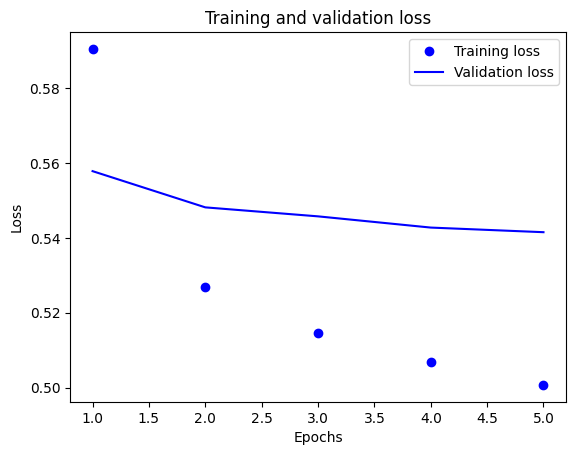

In [8]:
# Access training and validation loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss values
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Make some predictions 
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Calculate precision
precision = precision_score(y_test, binary_predictions)

# Calculate recall
recall = recall_score(y_test, binary_predictions)

# Calculate F1 score
f1 = f1_score(y_test, binary_predictions)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100) # 67.2% of the actual positive instances were correctly identified by the model.
print("F1 Score:", f1 ) # 0.635 suggests that the model achieves a reasonable balance between precision and recall.
print("ROC AUC Score:", roc_auc ) #  0.797 suggests that the model has good discrimination ability.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 73.47480106100795
Precision: 59.859154929577464
Recall: 66.40625
F1 Score: 0.6296296296296297
ROC AUC Score: 0.7991026606425703


## Above is just auxiliary  analysis for the dataset 

### Decision tree analysis 
Legend: class 0: non user of hard drugs, class 1: user of hard drugs 

* Precision: for class 0 is 0.74, which means that out of all instances predicted as class 0, 74% were truly class 0. Similarly, precision for class 1 is 0.48, indicating that out of all instances predicted as class 1, 48% were truly class 1.
* Recall: for class 0 (non user) is 0.72, meaning that the model correctly identified 72% of all actual class 0 instances. Recall for class 1 (user) is 0.50, indicating that the model correctly identified 50% of all actual class 1 instances.
* Accuracy: 64% of instances were correctly classified by the model.

Accuracy: 0.6419098143236074
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.71      0.73       249
           1       0.47      0.50      0.49       128

    accuracy                           0.64       377
   macro avg       0.60      0.61      0.61       377
weighted avg       0.65      0.64      0.64       377



[Text(0.5780800210363153, 0.975, 'x[3] <= 0.605\ngini = 0.464\nsamples = 1508\nvalue = [957, 551]'),
 Text(0.36895897918511955, 0.925, 'x[0] <= 0.21\ngini = 0.492\nsamples = 673\nvalue = [294, 379]'),
 Text(0.24367526572187778, 0.875, 'x[1] <= 0.0\ngini = 0.465\nsamples = 501\nvalue = [184, 317]'),
 Text(0.12386514614703277, 0.825, 'x[5] <= -0.629\ngini = 0.422\nsamples = 334\nvalue = [101, 233]'),
 Text(0.056465899025686446, 0.775, 'x[0] <= -0.515\ngini = 0.493\nsamples = 91\nvalue = [40, 51]'),
 Text(0.03675819309123118, 0.725, 'x[10] <= 1.087\ngini = 0.5\nsamples = 69\nvalue = [35, 34]'),
 Text(0.025686448184233834, 0.675, 'x[11] <= -0.853\ngini = 0.495\nsamples = 60\nvalue = [33, 27]'),
 Text(0.022143489813994686, 0.625, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.029229406554472984, 0.625, 'x[11] <= 0.241\ngini = 0.488\nsamples = 57\nvalue = [33, 24]'),
 Text(0.01771479185119575, 0.575, 'x[6] <= 0.245\ngini = 0.375\nsamples = 20\nvalue = [15, 5]'),
 Text(0.0141718334809566

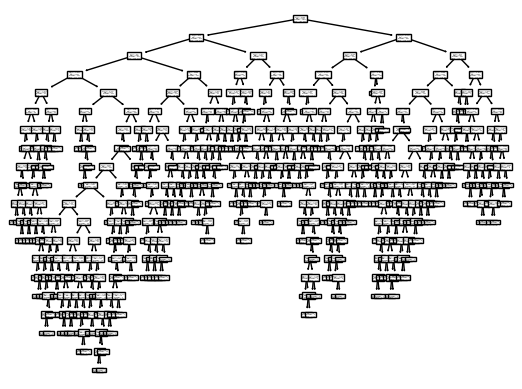

In [10]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
dt_report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(f"Classification Report: {dt_report}")


# Visualize the decision tree (optional)
tree.plot_tree(model)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       249
           1       0.58      0.55      0.56       128

    accuracy                           0.71       377
   macro avg       0.68      0.67      0.67       377
weighted avg       0.71      0.71      0.71       377



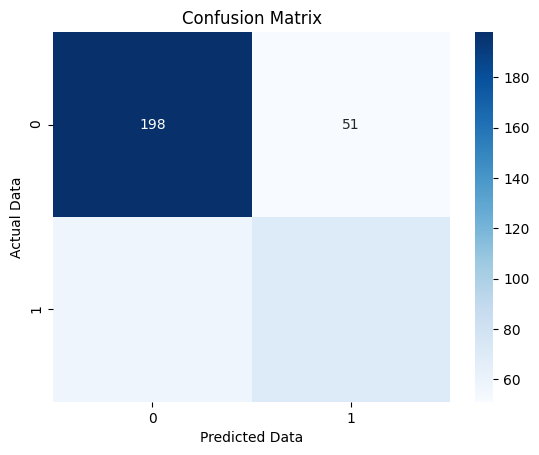

In [11]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# classification report
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("Classification Report for Random Forest:")
print(classification_rep_rf)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Data')
plt.ylabel('Actual Data')
plt.title('Confusion Matrix')
plt.show()

### K-Clustering analysis 

In [16]:
# Pull dataset from Kaggle
data = pd.read_csv('drug_consumption.csv')

# Display the first few rows of the dataset to understand its structure
print(data.head())

   ID      Age   Gender  Education  Country  Ethnicity   Nscore   Escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    Oscore   Ascore  ...  Ecstasy  Heroin  Ketamine Legalh  LSD Meth  \
0 -0.58331 -0.91699  ...      CL0     CL0       CL0    CL0  CL0  CL0   
1  1.43533  0.76096  ...      CL4     CL0       CL2    CL0  CL2  CL3   
2 -0.84732 -1.62090  ...      CL0     CL0       CL0    CL0  CL0  CL0   
3 -0.01928  0.59042  ...      CL0     CL0       CL2    CL0  CL0  CL0   
4 -0.45174 -0.30172  ...      CL1     CL0       CL0    CL1  CL0  CL0   

  Mushrooms Nicotine Semer  VSA  
0       CL0      CL2   CL0  CL0  
1       CL0      CL4   CL0  CL0  
2       

In [17]:
# Drop unnecessary columns
data = data.drop(columns=['ID'])

# Convert categorical variables to numerical
data = pd.get_dummies(data, drop_first=True)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


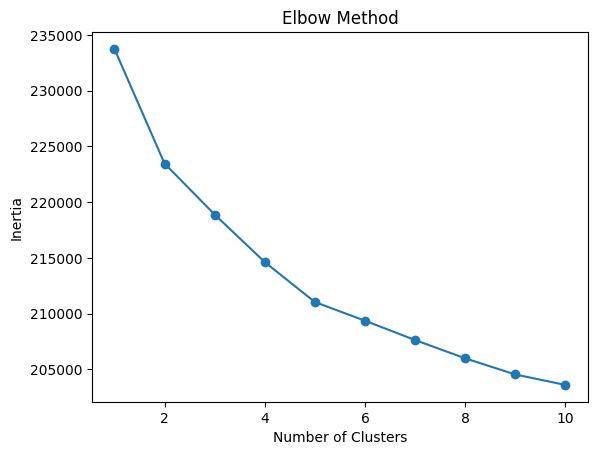

In [18]:
# Use the elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [19]:
# Choose the optimal number of clusters (e.g., k=3 from elbow method)
k = 3

# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the original dataset
data['Cluster'] = cluster_labels

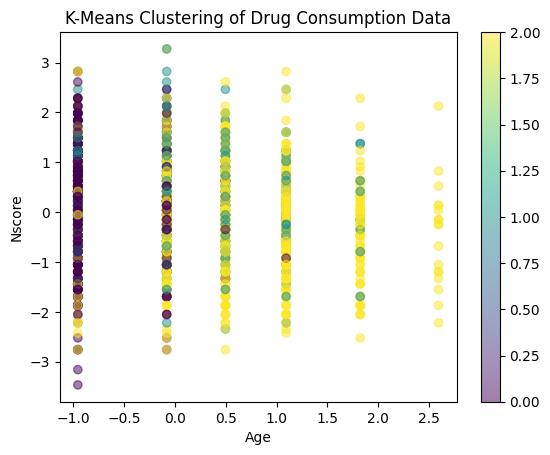

In [20]:
# Visualization (for 2D data)
plt.scatter(data['Age'], data['Nscore'], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering of Drug Consumption Data')
plt.xlabel('Age')
plt.ylabel('Nscore')
plt.colorbar()
plt.show()

## What Now?
First and foremost, this model can serve as a crucial tool for early intervention and support in public health initiatives aimed at addressing substance abuse. By identifying individuals at risk of drug usage based on various data sources such as social media activity, healthcare records, or demographic information, healthcare professionals can offer targeted interventions and resources to prevent escalation into more severe substance abuse problems. Moreover, law enforcement agencies can utilize the model to identify potential drug trafficking networks and illegal activities, thereby enhancing efforts in crime prevention and ensuring public safety. Furthermore, policymakers and healthcare providers can leverage insights from the model to develop evidence-based interventions, allocate resources effectively, and implement policies tailored to combat substance abuse issues within communities. Overall, your machine learning model holds the potential to significantly impact public health, safety, and policy-making efforts related to substance abuse prevention and intervention.